In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare data for convolution layers

In [2]:
# load all feature_channels

path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
file = 'Data_collection_weather/feature_channel_16x10.npy'

feature_channel = np.load(path+file, allow_pickle=False)
feature_channel.shape

(16, 10, 9, 204096)

In [3]:
# rearange the axis to get the examples as the first dimension for the use in tensorflow
feature_channel = np.moveaxis(feature_channel, -1, 0)
feature_channel.shape

(204096, 16, 10, 9)

In [4]:
# get rid of all nans - replace them with -1
feature_channel = np.nan_to_num(feature_channel, nan=-0.0001)

<AxesSubplot:>

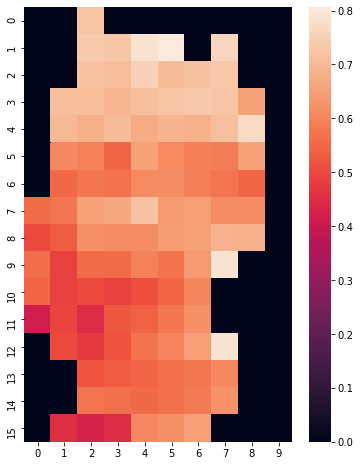

In [5]:
# make sure the change did work:
plt.figure(figsize = (6,8))
sns.heatmap(feature_channel[80_045,::-1,:,1])

In [6]:
# load the target values
path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
file_load = 'Data_collection_entsoe/Day_ahead_dataset.csv'
df_load = pd.read_csv(path+file_load)

df_load.shape

(204096, 10)

In [7]:
# keep only the target values
df_load.drop(columns=['index', 'Day ahead/System total load in MAW',
       'Day ahead/Solar in MAW',
       'Day ahead/Wind Onshore in MAW', 'Day ahead/Wind Offshore in MAW'], inplace=True)

print(df_load.shape)
df_load.head()

(204096, 5)


,Date,Realised/Solar in MAW,Realised/Wind Onshore in MAW,Realised/System total load in MAW,Realised/Wind Offshore in MAW
0,2014-12-31 23:00:00,0.0,8113.0,42976.0,520.0
1,2014-12-31 23:15:00,0.0,8092.0,42540.0,517.0
2,2014-12-31 23:30:00,0.0,8161.0,42638.0,514.0
3,2014-12-31 23:45:00,0.0,8146.0,42483.0,515.0
4,2015-01-01 00:00:00,0.0,8183.0,41917.0,515.0


In [8]:
df_load.describe()

,Realised/Solar in MAW,Realised/Wind Onshore in MAW,Realised/System total load in MAW,Realised/Wind Offshore in MAW
count,203400.000000,203556.000000,203996.000000,203567.000000
mean,4544.078899,9632.608840,55502.542001,1995.614697
std,6941.546136,7999.657244,10032.550893,1588.686852
min,0.000000,88.000000,29158.000000,0.000000
25%,0.000000,3556.000000,47109.000000,592.000000
50%,100.000000,7189.000000,55121.000000,1662.000000
75%,7344.000000,13432.000000,64352.250000,3110.000000
max,33194.000000,40930.000000,77853.000000,6990.000000


In [9]:
df_load = df_load.interpolate(method='ffill')

In [10]:
df_load.isnull().sum().sum()

0

In [11]:
def min_max_normalize_target_var(df):
    # fix the min and max according to phisical properties:
    X_max = 100_000
    
    for col in df.columns:
        df[col] /= X_max
        
    return df

In [12]:
df_load_norm = min_max_normalize_target_var(df_load.iloc[:,1:]) # avoid Date

In [13]:
df_load_norm.head()

,Realised/Solar in MAW,Realised/Wind Onshore in MAW,Realised/System total load in MAW,Realised/Wind Offshore in MAW
0,0.0,0.08113,0.42976,0.00520
1,0.0,0.08092,0.42540,0.00517
2,0.0,0.08161,0.42638,0.00514
3,0.0,0.08146,0.42483,0.00515
4,0.0,0.08183,0.41917,0.00515


In [14]:
np_load = df_load_norm.to_numpy(copy=True)

In [15]:
# check shape of target variable
np_load.shape

(204096, 4)

In [16]:
# test = feature_channel[:100_000,:,:,:]

In [17]:
# Define X_train, X_val, Y_train, Y_val
def train_val_test_split(feature_matrix, target_matrix, val_days, test_days):
    '''
    Split a time series data set into train, validation and test set
    INPUT:
    - feature_matrix: dataset in numpy array form with the set of features for training
    - target_matrix: dataset in numpy array form with the set of target variables
    - val_days: integer representing number of days to use for the validation set
    - test_days: integer representing number of days to use for the test set

    OUTPUT:
    - X_train: data set for training
    - y_train: matrix with target variables for training
    - X_val: data set for validation
    - y_val: matrix with target variables for validation
    - X_test: data set to test the model
    - y_val: matrix with target variables for testing
    '''

    print('The shape of the feature data set is: {}'.format(feature_matrix.shape))
    print('The shape of the target data set is: {}'.format(target_matrix.shape))

    rows_for_test = test_days*96
    rows_for_val = val_days*96

    #target_vars_for_test = target_vars.copy()
    #target_vars_for_test.append('Date')

    #df_features = df.drop(columns=target_vars_for_test).copy()
    #df_target = df[target_vars].copy()
    #df_target_test = df[target_vars_for_test].copy()

    X_train = feature_matrix[105_120:-(rows_for_test + rows_for_val)]
    y_train = target_matrix[105_120:-(rows_for_test + rows_for_val)]
    print('\n--------------------------------------------')
    print('The shape of the train set is: {}'.format(X_train.shape))
    print('The shape of the target variable is: {}'.format(y_train.shape))
    print('--------------------------------------------')

    X_val = feature_matrix[X_train.shape[0]+105_120:-(rows_for_test)]
    y_val = target_matrix[y_train.shape[0]+105_120:-(rows_for_test)]
    print('\n--------------------------------------------')
    print('The shape of the validation set is: {}'.format(X_val.shape))
    print('The shape of the target variable for the validation set is: {}'.format(y_val.shape))
    print('--------------------------------------------')

    X_test = feature_matrix[X_val.shape[0]+X_train.shape[0]+105_120:]
    y_test = target_matrix[y_val.shape[0]+X_train.shape[0]+105_120:]
    print('\n--------------------------------------------')
    print('The shape of the test set is: {}'.format(X_test.shape))
    print('The shape of the target variable for the test set is: {}'.format(y_test.shape))
    print('--------------------------------------------')

    return X_train, y_train, X_val, y_val, X_test, y_test

In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(feature_channel, np_load, 90, 90)

The shape of the feature data set is: (204096, 16, 10, 9)
The shape of the target data set is: (204096, 4)

--------------------------------------------
The shape of the train set is: (81696, 16, 10, 9)
The shape of the target variable is: (81696, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 16, 10, 9)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 16, 10, 9)
The shape of the target variable for the test set is: (8640, 4)
--------------------------------------------


# Set up the CNN

In [19]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3),
          activation='relu',
          input_shape=(16, 10, 9))
         )
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3),
          activation='relu')
         )
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 8, 32)         2624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 4, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 21,636
Trainable params: 21,636
Non-trainable params: 0
____________________________________________________

In [20]:
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mean_absolute_error'])

In [26]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs = 50,
                    validation_data=(X_val,y_val),
                    shuffle=False)

Epoch 1/50
1277/1277 [==============================] - 5s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0271 - val_loss: 0.0023 - val_mean_absolute_error: 0.0316
Epoch 2/50
1277/1277 [==============================] - 5s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0269 - val_loss: 0.0023 - val_mean_absolute_error: 0.0312
Epoch 3/50
1277/1277 [==============================] - 5s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0269 - val_loss: 0.0025 - val_mean_absolute_error: 0.0327
Epoch 4/50
1277/1277 [==============================] - 5s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0267 - val_loss: 0.0024 - val_mean_absolute_error: 0.0320
Epoch 5/50
1277/1277 [==============================] - 5s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0265 - val_loss: 0.0025 - val_mean_absolute_error: 0.0328
Epoch 6/50
1277/1277 [==============================] - 5s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0264 - val_loss: 0.0024 - val_mean_absolute_error: 0.0331
Epoc

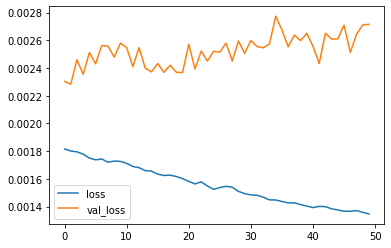

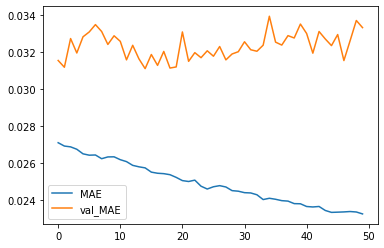

In [27]:
history.history
plt.plot(history.history["loss"],label = "loss")
plt.plot(history.history["val_loss"],label = "val_loss")
plt.legend()
plt.show()
plt.close()


history.history
plt.plot(history.history["mean_absolute_error"],label = "MAE")
plt.plot(history.history["val_mean_absolute_error"],label = "val_MAE")
plt.legend()
plt.show()
plt.close()

In [28]:
y_pred = model.predict(X_test)

In [29]:
y_pred.shape

(8640, 4)

In [30]:
  raise Exception("Stop the kernel!") 

Exception: Stop the kernel!

In [31]:
from sklearn.metrics import mean_absolute_error

def get_model_metrics(y_true_with_date, y_prediction):

    y_true = np.array(y_true_with_date.iloc[:,1])
    y_pred = np.array(y_prediction)


    # get the total error and the overall MAE

    overall_mae = mean_absolute_error(y_true, y_pred)
    absolute_error = overall_mae * len(y_true)

    print('\n----------------------------------------------')
    print(f'The absolute error (total actual minus  forecast) in MW is: {round(absolute_error, 2)}')
    print('----------------------------------------------\n')

    print('\n----------------------------------------------')
    print(f'The overall mean absolute error of the model in MW is: {overall_mae}')
    print('----------------------------------------------\n')

    # get the overall mean absolute scaled error (MASE)

    naive_forecast = y_true[1:]
    y_true_for_mase = y_true[:-1]
    mae_naive = mean_absolute_error(y_true_for_mase, naive_forecast)
    overall_mae_without_first_observation = mean_absolute_error(y_true[1:], y_pred[1:])

    overall_mase = overall_mae_without_first_observation/mae_naive

    print('\n----------------------------------------------')
    print(f'The overall mean absolute scaled error of the model in MW is: {overall_mase}')
    print('Please note: to calculate the MASE, the prediction for the first observation was omitted')
    print('----------------------------------------------\n')

    # get the MAE for every day and return a dataframe and charts

    time_stamp = np.array(
                 pd.to_datetime(y_true_with_date.iloc[:,0], format='%Y-%m-%d %H:%M:%S').dt.date
                 )

    date_list = list()
    y_true_list = list()
    y_pred_list = list()

    df = pd.DataFrame({'Date': time_stamp,
                       'y_true': y_true,
                       'y_pred': y_pred})

    list_of_days = sorted(list(set(df.Date.values)))

    for day in list_of_days:
        sub_df = df.query('Date == @day')
        date_list.append(sub_df.Date.values)
        y_true_list.append(sub_df.y_true.values)
        y_pred_list.append(sub_df.y_pred.values)

    mae_list = list()
    for i, j, k in zip(y_true_list, y_pred_list, date_list):
        MAE = mean_absolute_error(i, j)
        mae_list.append(MAE)

    del df

    df = pd.DataFrame({'day':list_of_days, 'MAE': mae_list},)

    print('\n----------------------------------------------')
    print('This function also returns a dataframe with the MAE for each day')
    print('----------------------------------------------\n')

    return df

In [39]:
print(y_test[:,3])
print(y_pred[:,3])

[0.05294 0.05353 0.05336 ... 0.04525 0.04525 0.04525]
[0.03758285 0.03858622 0.0392504  ... 0.03729891 0.03729891 0.03729891]


In [40]:
# re-scaled the results
y_test *= 100_000
y_pred *= 100_000

print(y_test[:,3])
print(y_pred[:,3])

[5294. 5353. 5336. ... 4525. 4525. 4525.]
[3758.2852 3858.622  3925.0403 ... 3729.891  3729.891  3729.891 ]


In [41]:
# create dataframe for y_test with dates

y_true_with_date = pd.DataFrame({'Date':df_load.iloc[-y_test.shape[0]:,0],
                                 'solar':y_test[:,0], 
                                 'wind_onshore':y_test[:,1], 
                                 'load':y_test[:,2], 
                                 'wind_offshore':y_test[:,3]})

In [ ]:
y_true_with_date.iloc[:,[0,1]]

In [43]:
list_names = ["solar","wind_onshore", "load", "wind_offshore"]

metrics_dict = dict()
for i in range(len(y_pred[0])):
    print("\n=================================")
    print(f"{list_names[i]}")
    metrics_dict[list_names[i]] = get_model_metrics(y_true_with_date.iloc[:,[0,i+1]],y_pred[:,i])
    print("=================================\n")


solar

----------------------------------------------
The absolute error (total actual minus  forecast) in MW is: 23700874.07
----------------------------------------------


----------------------------------------------
The overall mean absolute error of the model in MW is: 2743.1567208304728
----------------------------------------------


----------------------------------------------
The overall mean absolute scaled error of the model in MW is: 6.8139598208766765
Please note: to calculate the MASE, the prediction for the first observation was omitted
----------------------------------------------


----------------------------------------------
This function also returns a dataframe with the MAE for each day
----------------------------------------------



wind_onshore

----------------------------------------------
The absolute error (total actual minus  forecast) in MW is: 21924647.1
----------------------------------------------


---------------------------------------------

In [49]:
import plotly.express as px

In [47]:
metrics_dict['solar']

,day,MAE
0,2020-07-28,351.587271
1,2020-07-29,4442.771411
2,2020-07-30,3069.740216
3,2020-07-31,4000.461457
4,2020-08-01,3350.992152
...,...,...
86,2020-10-22,2399.857822
87,2020-10-23,1148.854641
88,2020-10-24,1368.011587
89,2020-10-25,1864.474076
